In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Generate dummy sequence data

train: torch.Size([10, 1990, 1]) torch.Size([1990, 1])
test: torch.Size([10, 990, 1]) torch.Size([990, 1])


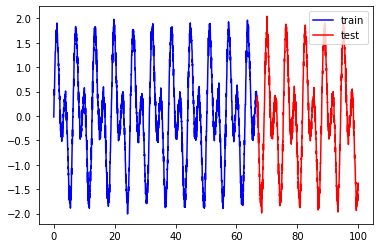

In [2]:
num_data = 3000
len_sequence = 10

raw_x = np.linspace(0.0, 100.0, num_data)
raw_y = np.sin(raw_x) + np.sin(2*raw_x) + np.random.normal(0, 0.1, num_data)

num_train=2000
num_test = num_data -num_train
train_input = np.zeros((num_train - len_sequence, len_sequence), dtype=np.float32)
train_output = np.zeros(num_train - len_sequence, dtype=np.float32)
test_input = np.zeros((num_test - len_sequence, len_sequence), dtype=np.float32)
test_output = np.zeros(num_test - len_sequence, dtype=np.float32)


for i in range(num_train - len_sequence):
    train_input[i] = raw_y[i:i+len_sequence]
    train_output[i] = raw_y[i+len_sequence]

for i in range(num_test - len_sequence):
    test_input[i] = raw_y[num_test + i: num_test + i + len_sequence]
    test_output[i] = raw_y[num_test + i +len_sequence]

train_input = torch.as_tensor(train_input).transpose_(0, 1).unsqueeze_(2)
train_output = torch.as_tensor(train_output).unsqueeze_(1)
test_input = torch.as_tensor(test_input).transpose_(0,1).unsqueeze_(2)
test_output = torch.as_tensor(test_output).unsqueeze_(1)


print("train:", train_input.shape, train_output.shape)
print("test:", test_input.shape, test_output.shape)

plt.plot(raw_x[:num_train], raw_y[:num_train], 'b-', label='train')
plt.plot(raw_x[num_train:], raw_y[num_train:], 'r-', label='test')
plt.legend()

plt.savefig("train_test.png")
plt.show()


# Generate model

In [3]:
class RNN(nn.Module):
    def __init__(self, in_features, out_features, hidden_size):
        super(RNN, self).__init__()

        #* Get inputs
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_size = hidden_size

        #* Generate matrixes for vanilla RNN
        self.W_i = nn.Linear(self.in_features, self.hidden_size, bias=False)
        self.W_h = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.W_o = nn.Linear(self.hidden_size, self.out_features, bias=False)

        #* Activations
        self.activation = nn.Tanh()

    def init_hidden(self, x):
        return torch.zeros(x.shape[0], self.hidden_size)

    def forward(self, x, h):
        h = self.activation(self.W_i(x) + self.W_h(h))
        y = self.W_o(h)
        return y, h

model = RNN(in_features=1, out_features=1, hidden_size=50)
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.005)

# Train the model

In [4]:
max_epoch = 100
model.train()
for epoch in range(max_epoch):
    #* Initialize hidden state
    for x in train_input:
        h = model.init_hidden(x)
        break

    #* Feed forward
    for x in train_input:
        y,h = model(x, h)

    #* Get loss
    loss = loss_func(y, train_output)
    # print(loss.item())

    #* Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Test the model

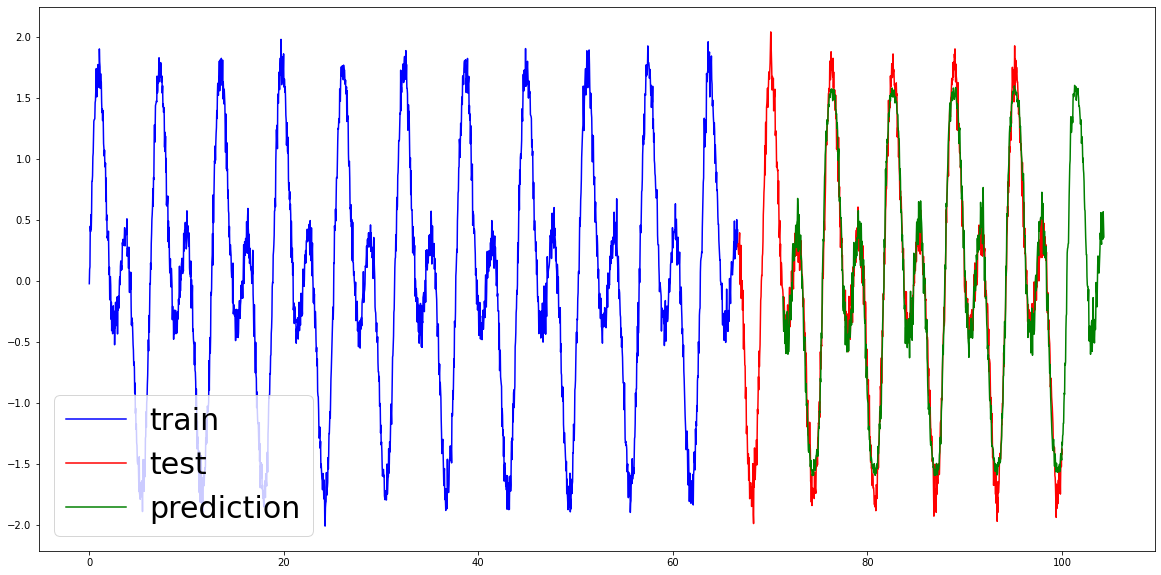

In [5]:
prediction = []
model.eval()
with torch.no_grad():
    #* Initialize hidden state
    for x in test_input:
        h = model.init_hidden(x)
        break

    #* Feed forward
    for x in test_input:
        y, h = model(x, h)
    prediction = y

plt.figure(figsize=(20, 10))
plt.plot(raw_x[:num_train], raw_y[:num_train],
         color='b', label='train')
plt.plot(raw_x[num_train:], raw_y[num_train:],
         color='r', label='test')
plt.plot(raw_x[num_train + len_sequence:] + 4.3, prediction,
         color='g', label='prediction')
plt.legend(fontsize=30)
plt.savefig("test.png")
plt.show()
